In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

In [4]:
df_article = pd.read_csv('./data/zhuanlan_article.csv',header=0)
df_info = pd.read_csv('./data/zhuanlan_info.csv',header=None)
df_info.columns = ['zhuanlan_name','zhuanlan_author','description','zhuanlan_url','articles_count','followers']

df_data = pd.merge(df_info[['zhuanlan_name','zhuanlan_url','followers']],\
                  df_article[['zhuanlan_url','title','article_url','publishedTime','commentsCount','likesCount','content']],\
                  how = 'inner',on = 'zhuanlan_url')

In [6]:
len(df_article)

6587

In [7]:
df_data.loc[:,'publishedTime'] = df_data.loc[:,'publishedTime'].map(lambda x : x.split('T')[0])
df_data = df_data.sort_values(by=['zhuanlan_name','publishedTime'])

# 提取专栏的首次发文时间和最后一次发文时间

In [8]:
first_pub = df_data[['zhuanlan_name','publishedTime']].copy()
first_pub.drop_duplicates(subset='zhuanlan_name', keep='first', inplace=True)
first_pub.columns = ['zhuanlan_name','first_publishedTime']

last_pub = df_data[['zhuanlan_name','publishedTime']].copy()
last_pub.drop_duplicates(subset='zhuanlan_name', keep='last', inplace=True)
last_pub.columns = ['zhuanlan_name','last_publishedTime']

df_data = pd.merge(df_data,first_pub,how='left',on='zhuanlan_name')
df_data = pd.merge(df_data,last_pub,how='left',on='zhuanlan_name')

In [9]:
df_data['publishedTime'] = df_data['publishedTime'].map(lambda x : datetime.strptime(x,'%Y-%m-%d'))
df_data['first_publishedTime'] = df_data['first_publishedTime'].map(lambda x : datetime.strptime(x,'%Y-%m-%d'))
df_data['last_publishedTime'] = df_data['last_publishedTime'].map(lambda x : datetime.strptime(x,'%Y-%m-%d'))

## 增加三列作为辅助列计算专栏的关注人数修正值

计算每篇文章的发文日期距离专栏开通日期的天数，最后 +1 做平滑，方便后面的“除法运算”

In [10]:
df_data['published_day'] = df_data['publishedTime'] - df_data['first_publishedTime']
df_data['published_day'] = df_data['published_day'].map(lambda x: x.days) + 1

计算最后一次发文日期距离第一篇文章的发文日期的天数，最后 +1 做平滑，方便后面的“除法运算”

In [11]:
df_data['published_w_day'] = df_data['last_publishedTime'] - df_data['first_publishedTime']
df_data['published_w_day'] = df_data['published_w_day'].map(lambda x: x.days + 1)

### 关注人数修正值计算方法

假设专栏的关注人数是以直线增长的，如下图所示
![](pic1.png)

In [12]:
df_data.loc[:,'correction_followers'] = df_data['published_day']/df_data['published_w_day']
df_data.loc[:,'correction_followers'] = df_data.loc[:,'correction_followers'] * df_data.loc[:,'followers']
df_data.loc[:,'correction_followers'] = df_data.loc[:,'correction_followers'].map(lambda x : round(x)+1)

In [13]:
del df_data['first_publishedTime']
del df_data['last_publishedTime']
del df_data['published_day']
del df_data['published_w_day']

# 计算文章受欢迎指数

计算方法：

$$(commentCount + \frac{1}{2} * likeCount)*  \frac{1}{log_{5}(correction\_followers +5)}$$

In [14]:
df_data['comLike'] = df_data['commentsCount'] + 0.5 * df_data['likesCount']
df_data.loc[:,'correction_followers_log'] = df_data['correction_followers'].map(lambda x: 1/math.log(x+5,5))
df_data.loc[:,'article_PPI'] = df_data['comLike'] * df_data['correction_followers_log']
df_data['article_PPI'] = df_data['article_PPI'].astype('int')

In [15]:
del df_data['comLike']
del df_data['correction_followers_log']

In [16]:
df_data = df_data.sort_values(by='article_PPI',ascending=False).reset_index()

In [17]:
df_data[['title','article_PPI','article_url','publishedTime','commentsCount','likesCount','zhuanlan_name','followers']].head(10)

,title,article_PPI,article_url,publishedTime,commentsCount,likesCount,zhuanlan_name,followers
0,打算在知乎送一波邀请码：PMCAFF全球最大的产品经理社区（已结束）,774,https://zhuanlan.zhihu.com/p/25310515,2017-02-19,3729.0,258.0,PMCAFF产品社区,3767
1,AI可能真的要代替插画师了……,475,https://zhuanlan.zhihu.com/p/28488946,2017-08-13,399.0,4190.0,AI Insight,6004
2,十款被人忽视的堪称神器的软件 好用又实用,419,https://zhuanlan.zhihu.com/p/26740908,2017-05-06,102.0,2511.0,程序猿数据爱好者,3802
3,强烈推荐的机器学习，深度学习课程以及python库,402,https://zhuanlan.zhihu.com/p/24768878,2017-01-07,82.0,1333.0,深度学习炼丹师,1494
4,当你们羡慕IT程序员月薪两三万时，请看深圳这些科技公司的夜晚,371,https://zhuanlan.zhihu.com/p/26566138,2017-04-25,389.0,628.0,程序猿数据爱好者,3802
5,AI玩微信跳一跳的正确姿势 --跳一跳Auto-Jump算法详解,323,https://zhuanlan.zhihu.com/p/32636329,2018-01-04,258.0,2503.0,学术兴趣小组,1809
6,深度学习岗位面试问题整理笔记,309,https://zhuanlan.zhihu.com/p/25005808,2017-02-09,20.0,915.0,许韩VS许韩,694
7,深层学习为何要“Deep”（上）,309,https://zhuanlan.zhihu.com/p/22888385,2016-10-12,83.0,1071.0,超智能体,8491
8,人工智能打脸史,298,https://zhuanlan.zhihu.com/p/20622308,2016-03-05,279.0,2697.0,Hello 陈然！,11209
9,AI玩微信跳一跳的正确姿势 --跳一跳Auto-Jump算法详解,292,https://zhuanlan.zhihu.com/p/32636329,2018-01-04,258.0,2503.0,人工智能应用系列,4069


# LDA主题模型

In [18]:
import jieba
import re
import pickle
from gensim import models,corpora,similarities

jieba.load_userdict('jieba_dict.txt')
stop_word = pickle.load(open('stop_word.pkl','rb'))
stop_word.append('\n')

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/s5/cxqfsb816f36h8gp706x5kjm0000gn/T/jieba.cache
Loading model cost 1.047 seconds.
Prefix dict has been built succesfully.


In [19]:
def deal_data(text):
    text = text.upper()
    text = re.sub('[0-9]+','',text)
    text = re.sub('ML','机器学习',text)
    text = re.sub('NLP','自然语言处理',text)
    text = re.sub('DL','深度学习',text)
    text = re.sub('AI','人工智能',text)
    text = re.sub('DEEP LEARNING','深度学习',text)
    text = re.sub('MACHINE LEARNING','机器学习',text)
    text = re.sub('NEURAL NETWORK','神经网络',text)
    text = re.sub('CNN','卷积神经网络',text)
    text = re.sub('RNN','循环神经网络',text)
    text = jieba.cut(text)
    text = [word for word in text if word not in stop_word]
    text = [word for word in text if len(word)>1]
    return text

def make_corpus(data):
    corpus = []
    for line in data:
        text = str(line)
        text = deal_data(text)
        corpus.append(text)
    return corpus

In [20]:
corpus = make_corpus(df_data['content'])

In [21]:
dictionary = corpora.Dictionary(corpus)
corpus_ = [dictionary.doc2bow(text) for text in corpus]
tfidf = models.TfidfModel(corpus_)
corpus_tfidf = tfidf[corpus_]

In [22]:
lda = models.LdaModel(corpus_tfidf, id2word = dictionary, num_topics = 200,alpha=1)

In [23]:
lda.print_topics(num_topics=10, num_words=20)

[(100,
  '0.013*"CH" + 0.011*"单带" + 0.007*"复清" + 0.007*"分改" + 0.006*"亿元" + 0.006*"FROM" + 0.005*"万美元" + 0.005*"发言" + 0.005*"CONSTANT" + 0.005*"巨头" + 0.004*"追求" + 0.004*"斜率" + 0.004*"指注" + 0.004*"手段" + 0.003*"高深" + 0.003*"结束" + 0.003*"吸引力" + 0.003*"后台" + 0.003*"互联网" + 0.003*"YOU"'),
 (115,
  '0.013*"投入" + 0.009*"意识" + 0.008*"COM" + 0.006*"POOL" + 0.006*"MAX" + 0.005*"真实" + 0.004*"REGULARIZATION" + 0.004*"目标" + 0.004*"UNET" + 0.004*"巨量" + 0.004*"超平面" + 0.004*"分段" + 0.003*"中心" + 0.003*"FACE" + 0.003*"不行" + 0.003*"便利" + 0.003*"计划" + 0.003*"三大" + 0.003*"激动人心" + 0.003*"视频"'),
 (73,
  '0.009*"做好" + 0.005*"被迫" + 0.004*"这方面" + 0.004*"下次" + 0.004*"笔记" + 0.004*"未来" + 0.003*"排序" + 0.003*"BASIC" + 0.003*"拆分" + 0.003*"ANY" + 0.003*"单例" + 0.002*"花费" + 0.002*"YET" + 0.002*"REPORT" + 0.002*"嘉宾" + 0.002*"系数" + 0.002*"NB" + 0.002*"HELLO" + 0.002*"旨在" + 0.002*"进程"'),
 (168,
  '0.014*"社会" + 0.012*"老婆" + 0.011*"期权" + 0.009*"步骤" + 0.007*"机制" + 0.006*"AXIS" + 0.006*"理财" + 0.006*"CHANNEL" + 0.005*"资金" + 0.004*

In [24]:
doc_topic = []
for i in range(len(corpus_)):
    test_bow = corpus_[i]
    test_lda = lda[test_bow]
    try:
        topic = sorted(test_lda,key = lambda x:x[1],reverse = True)[0][0]
    except:
        topic = 301
    doc_topic.append(topic)

In [25]:
from collections import Counter

## 文章数最多的主题TOP10

In [39]:
sort_topic = dict(Counter(doc_topic))
del sort_topic[301]

In [40]:
sort_topic = sorted(sort_topic.items(),key=lambda d: d[1],reverse=False)

In [42]:
sort_topic[-10:]

[(2, 68),
 (87, 69),
 (147, 71),
 (46, 72),
 (14, 84),
 (165, 87),
 (49, 94),
 (15, 102),
 (115, 114),
 (128, 122)]

In [43]:
lda.show_topic(128, topn=15)

[('C++', 0.0073621177573112741),
 ('掘金', 0.0060146858787312836),
 ('SAAS', 0.0050183708462674332),
 ('笔记', 0.0046640153814208433),
 ('作业', 0.0043370514756625265),
 ('技能', 0.0040290091322048929),
 ('翻译', 0.0038562952312231544),
 ('编码', 0.0035340887845607236),
 ('语义', 0.0034494549632494462),
 ('复习', 0.0027977269082461479),
 ('经历', 0.0027631620292495416),
 ('天时', 0.0025586528042633996),
 ('高级', 0.0024393322888484107),
 ('卷积神经网络', 0.0024319713220106428),
 ('过程', 0.0024202177546965406)]

In [44]:
lda.show_topic(115, topn=15)

[('投入', 0.013180937683156795),
 ('意识', 0.0089430273236890782),
 ('COM', 0.0078722954813902936),
 ('POOL', 0.0055504297670982417),
 ('MAX', 0.005501636955675719),
 ('真实', 0.0050442454040778789),
 ('REGULARIZATION', 0.0043708265251305107),
 ('目标', 0.0042107505735980025),
 ('UNET', 0.0041983303941388042),
 ('巨量', 0.0040715031821778429),
 ('超平面', 0.0037196956364697626),
 ('分段', 0.0035627542294869199),
 ('中心', 0.0034166993019445206),
 ('FACE', 0.0033606492063201722),
 ('不行', 0.0032838056894701857)]

In [45]:
lda.show_topic(15, topn=15)

[('清醒', 0.023656326118994819),
 ('KERAS', 0.013858695074069083),
 ('智能', 0.012530462331618357),
 ('熟练掌握', 0.0058479703779042479),
 ('BOUNDING', 0.0050060850260313459),
 ('有人', 0.0046312826926177345),
 ('OP', 0.0045685625803682682),
 ('CLASS', 0.0039018834381273097),
 ('衍生', 0.0036573121267381875),
 ('细胞', 0.0036384455465580312),
 ('BIAS', 0.0034219907866387855),
 ('ON', 0.0031253452688890558),
 ('期望', 0.0029981800635791251),
 ('摘要', 0.0028886260461453697),
 ('点对点', 0.0027572052000631115)]

## 200个主题的文档频数分布

In [46]:
df_data.loc[:,'topic'] = doc_topic

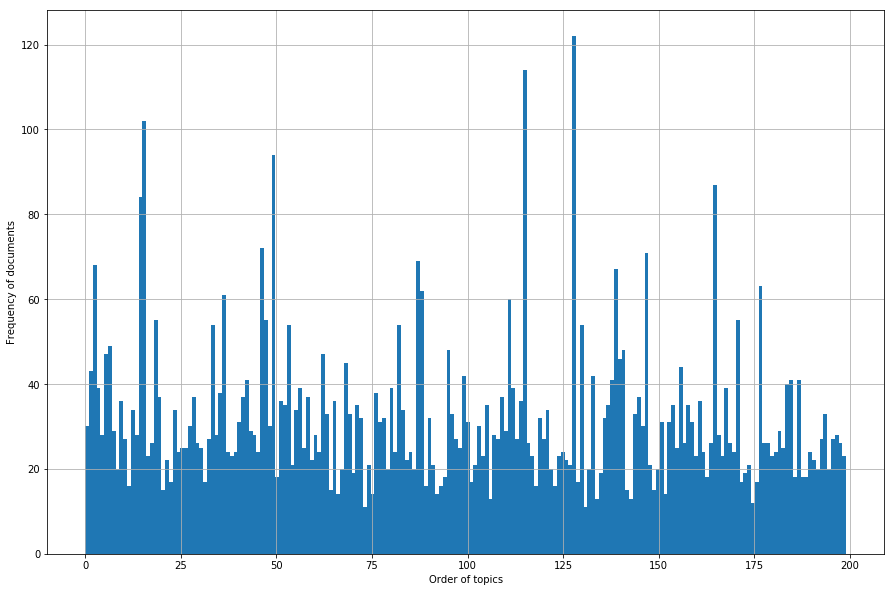

In [49]:
plt.figure(figsize=(15,10))
df_data.loc[df_data['topic']<200,'topic'].hist(bins=200)
plt.ylabel('Frequency of documents')
plt.xlabel('Order of topics')
plt.show()

## 推荐指数TOP100文章主题分布

In [50]:
top100_article = df_data.copy()
del top100_article['content']

top100_article= top100_article[:100]

In [53]:
del top100_article['index']
top100_article.head()

,zhuanlan_name,zhuanlan_url,followers,title,article_url,publishedTime,commentsCount,likesCount,correction_followers,article_PPI,topic
0,PMCAFF产品社区,https://zhuanlan.zhihu.com/pmcaff,3767,打算在知乎送一波邀请码：PMCAFF全球最大的产品经理社区（已结束）,https://zhuanlan.zhihu.com/p/25310515,2017-02-19,3729.0,258.0,3021,774,175
1,AI Insight,https://zhuanlan.zhihu.com/ai-insight,6004,AI可能真的要代替插画师了……,https://zhuanlan.zhihu.com/p/28488946,2017-08-13,399.0,4190.0,4627,475,138
2,程序猿数据爱好者,https://zhuanlan.zhihu.com/c_94187513,3802,十款被人忽视的堪称神器的软件 好用又实用,https://zhuanlan.zhihu.com/p/26740908,2017-05-06,102.0,2511.0,177,419,40
3,深度学习炼丹师,https://zhuanlan.zhihu.com/zhangbingyang,1494,强烈推荐的机器学习，深度学习课程以及python库,https://zhuanlan.zhihu.com/p/24768878,2017-01-07,82.0,1333.0,15,402,42
4,程序猿数据爱好者,https://zhuanlan.zhihu.com/c_94187513,3802,当你们羡慕IT程序员月薪两三万时，请看深圳这些科技公司的夜晚,https://zhuanlan.zhihu.com/p/26566138,2017-04-25,389.0,628.0,16,371,50


In [55]:
lda.show_topic(138, topn=15)

[('YOUR', 0.0075702163995136048),
 ('人物', 0.0066032505003786645),
 ('天使', 0.0060960710748931357),
 ('放在', 0.0059051746993017623),
 ('EXP', 0.0043571927437047854),
 ('招聘', 0.0040529178166156341),
 ('提速', 0.0040197550573014837),
 ('意愿', 0.0037170939759279208),
 ('公司', 0.0036406791748898617),
 ('产品设计', 0.0034320415731722096),
 ('苹果公司', 0.0033979887195511381),
 ('TARGET', 0.0033507978130662614),
 ('几天', 0.0032097836781881084),
 ('目标', 0.0030264953620167344),
 ('美国', 0.0027946388847278647)]

In [57]:
len(top100_article['topic'].value_counts())

64

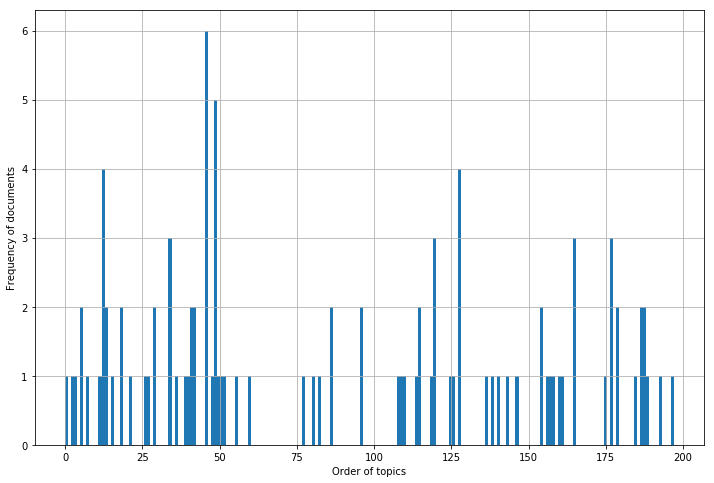

In [59]:
plt.figure(figsize=(12,8))
top100_article['topic'].hist(bins=200)
plt.ylabel('Frequency of documents')
plt.xlabel('Order of topics')
plt.show()

In [ ]:
dictionary = corpora.Dictionary(corpus)
corpus_ = [dictionary.doc2bow(text) for text in corpus]
tfidf = models.TfidfModel(corpus_)
corpus_tfidf = tfidf[corpus_]

In [60]:
len(dictionary)

130527

## 使用TF-IDF提取每篇文章的关键词

In [100]:
key_words_list = []
for i in range(100):
    doc_tfidf = corpus_tfidf[i]
    sort_doc_tfidf = sorted(doc_tfidf,key = lambda x:x[1],reverse = True)
    key_words = [word_id[0] for word_id in sort_doc_tfidf[:15]]
    key_words = [dictionary[i] for i in key_words]
    key_words = '、'.join(key_words)
    key_words_list.append(key_words)

In [103]:
key_words_list[2]

'软件、神器、下载、迅雷、硕鼠、卸载、IDM、视频、网页、注册表、残留、一款、WIN、网站、PDF'

## 文章摘要

In [118]:
from sklearn import feature_extraction  
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer  


def split_sentence(text, punctuation_list='!?。！？'):
    """
    将文本段安装标点符号列表里的符号切分成句子，将所有句子保存在列表里。
    """
    sentence_set = []
    inx_position = 0         #索引标点符号的位置
    char_position = 0        #移动字符指针位置
    for char in text:
        char_position += 1
        if char in punctuation_list:
            next_char = list(text[inx_position:char_position+1]).pop()
            if next_char not in punctuation_list:
                sentence_set.append(text[inx_position:char_position])
                inx_position = char_position
    if inx_position < len(text):
        sentence_set.append(text[inx_position:])

    sentence_with_index = {i:sent for i,sent in enumerate(sentence_set)} #dict(zip(sentence_set, range(len(sentences))))
    return sentence_set,sentence_with_index

def get_tfidf_matrix(sentence_set,stop_word):
    corpus = []
    for sent in sentence_set:
        sent_cut = jieba.cut(sent)
        sent_list = [word for word in sent_cut if word not in stop_word]
        sent_str = ' '.join(sent_list)
        corpus.append(sent_str)

    vectorizer=CountVectorizer()
    transformer=TfidfTransformer()
    tfidf=transformer.fit_transform(vectorizer.fit_transform(corpus))
    # word=vectorizer.get_feature_names()
    tfidf_matrix=tfidf.toarray()
    return np.array(tfidf_matrix)

def get_sentence_with_words_weight(tfidf_matrix):
    sentence_with_words_weight = {}
    for i in range(len(tfidf_matrix)):
        sentence_with_words_weight[i] = np.sum(tfidf_matrix[i])

    max_weight = max(sentence_with_words_weight.values()) #归一化
    min_weight = min(sentence_with_words_weight.values())
    for key in sentence_with_words_weight.keys():
        x = sentence_with_words_weight[key]
        sentence_with_words_weight[key] = (x-min_weight)/(max_weight-min_weight)

    return sentence_with_words_weight

def get_sentence_with_position_weight(sentence_set):
    sentence_with_position_weight = {}
    total_sent = len(sentence_set)
    for i in range(total_sent):
        sentence_with_position_weight[i] = (total_sent - i) / total_sent
    return sentence_with_position_weight

def similarity(sent1,sent2):
    """
    计算余弦相似度
    """
    return np.sum(sent1 * sent2) / (1e-6+np.sqrt(np.sum(sent1 * sent1)) *\
                                    np.sqrt(np.sum(sent2 * sent2)))

def get_similarity_weight(tfidf_matrix):
    sentence_score = collections.defaultdict(lambda :0.)
    for i in range(len(tfidf_matrix)):
        score_i = 0.
        for j in range(len(tfidf_matrix)):
            score_i += similarity(tfidf_matrix[i],tfidf_matrix[j])
        sentence_score[i] = score_i

    max_score = max(sentence_score.values()) #归一化
    min_score = min(sentence_score.values())
    for key in sentence_score.keys():
        x = sentence_score[key]
        sentence_score[key] = (x-min_score)/(max_score-min_score)

    return sentence_score

def ranking_base_on_weigth(sentence_with_words_weight,
                            sentence_with_position_weight,
                            sentence_score, feature_weight = [1.5,1,1]):
    sentence_weight = collections.defaultdict(lambda :0.)
    for sent in sentence_score.keys():
        sentence_weight[sent] = feature_weight[0]*sentence_with_words_weight[sent] +\
                                feature_weight[1]*sentence_with_position_weight[sent] +\
                                feature_weight[2]*sentence_score[sent]

    sort_sent_weight = sorted(sentence_weight.items(),key=lambda d: d[1], reverse=True)
    return sort_sent_weight

def get_summarization(sentence_with_index,sort_sent_weight,topK_ratio =0.1):
    topK = int(len(sort_sent_weight)*topK_ratio)
    summarization_sent = sorted([sent[0] for sent in sort_sent_weight[:topK]])
    
    summarization = []
    for i in summarization_sent:
        summarization.append(sentence_with_index[i])

    summary = ''.join(summarization)
    return summary


def run(text):
    sentence_set,sentence_with_index = split_sentence(text, punctuation_list='!?。！？')
    tfidf_matrix = get_tfidf_matrix(sentence_set,stop_word)
    sentence_with_words_weight = get_sentence_with_words_weight(tfidf_matrix)
    sentence_with_position_weight = get_sentence_with_position_weight(sentence_set)
    sentence_score = get_similarity_weight(tfidf_matrix)
    sort_sent_weight = ranking_base_on_weigth(sentence_with_words_weight,
                                                sentence_with_position_weight,
                                                sentence_score, feature_weight = [1.5,1,1])
    summarization = get_summarization(sentence_with_index,sort_sent_weight,topK_ratio =0.1)
    return summarization

In [119]:
summary_list = []
for i in range(100):
    text = df_data.loc[i,'content']
    summary = run(text)
    summary_list.append(summary)

In [122]:
top100_article.loc[:,'summary'] = summary_list

In [123]:
top100_article.head()

,zhuanlan_name,zhuanlan_url,followers,title,article_url,publishedTime,commentsCount,likesCount,correction_followers,article_PPI,topic,tfidf_key_word,summary
0,PMCAFF产品社区,https://zhuanlan.zhihu.com/pmcaff,3767,打算在知乎送一波邀请码：PMCAFF全球最大的产品经理社区（已结束）,https://zhuanlan.zhihu.com/p/25310515,2017-02-19,3729.0,258.0,3021,774,175,PMCAFF、邀请、社区、产品、平台、成本、半封闭、此帖、FREELANCER、十年、经理、...,采用邀请码机制主要目的在于降低管理成本，PMCAFF作为一个坚持了十年的公益平台，如果要像知...
1,AI Insight,https://zhuanlan.zhihu.com/ai-insight,6004,AI可能真的要代替插画师了……,https://zhuanlan.zhihu.com/p/28488946,2017-08-13,399.0,4190.0,4627,475,138,EYES、属性、生成、CGAN、人物、GLASSES、MOE、网站、二次元、PDF、GAN、...,》（论文地址：https://makegirlsmoe.github.io/assets/p...
2,程序猿数据爱好者,https://zhuanlan.zhihu.com/c_94187513,3802,十款被人忽视的堪称神器的软件 好用又实用,https://zhuanlan.zhihu.com/p/26740908,2017-05-06,102.0,2511.0,177,419,40,软件、神器、下载、迅雷、硕鼠、卸载、IDM、视频、网页、注册表、残留、一款、WIN、网站、PDF,二、硕鼠，可以下载几乎国内所有主流视频网站上的视频。一款互联网备份软件，从1996年以来，已...
3,深度学习炼丹师,https://zhuanlan.zhihu.com/zhangbingyang,1494,强烈推荐的机器学习，深度学习课程以及python库,https://zhuanlan.zhihu.com/p/24768878,2017-01-07,82.0,1333.0,15,402,42,COURESA、公开课、辅导班、课程、斯坦福大学、NG、讲课、李飞飞、课件、推荐、必备、WE...,本着两条原则推荐一波机器学习，深度学习的课程以及常用的库：1.不建议报辅导班。
4,程序猿数据爱好者,https://zhuanlan.zhihu.com/c_94187513,3802,当你们羡慕IT程序员月薪两三万时，请看深圳这些科技公司的夜晚,https://zhuanlan.zhihu.com/p/26566138,2017-04-25,389.0,628.0,16,371,50,加班、深圳、半夜、换来、两三万、来之不易、羡慕、高薪、月薪、职业、离不开、农民房、二十七八岁...,在深圳有这样一群人，住着十几平方的城中村农民房，二十七八岁没有女朋友，每天早出晚归，月薪两三...


In [130]:
with open('top100_articles.txt','w') as f:
    for i in top100_article.index:
        f.write('## ['+top100_article.loc[i,'title']+']('+ top100_article.loc[i,'article_url']+')  ')
        f.write('推荐指数：'+str(top100_article.loc[i,'article_PPI'])+'\n\n')
        f.write('**关键词：**'+top100_article.loc[i,'tfidf_key_word']+'\n\n')
        f.write('**文章摘要：**'+top100_article.loc[i,'summary']+'\n\n')
        f.write('**发表日期：**'+str(top100_article.loc[i,'publishedTime']).split()[0]+'，  ')
        f.write('**评论数：**'+str(top100_article.loc[i,'commentsCount'])+'，  ')
        f.write('**点赞数：**'+str(top100_article.loc[i,'likesCount']))
        f.write('\n---\n\n')